In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from fastai.vision.all import *
from torchvision import transforms
import torchvision.transforms.functional as TF
import ipywidgets as widgets
from PIL import Image as pilImage
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
sys.path.append("../") 
%load_ext autoreload
%autoreload 2
from src.utils import *
from src.gradcam import GuidedGradCam
from src.augmentationImpactAnalyzer import AugmentationImpactAnalyzer 

ROOT_DIR =  Path('../')
DATA_PATH = ROOT_DIR/'data/'
IMGS_PATH = ROOT_DIR/'imgs/'

In [2]:
np.random.seed(0)
torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

## Prepare Toy Dataset


<AxesSubplot:>

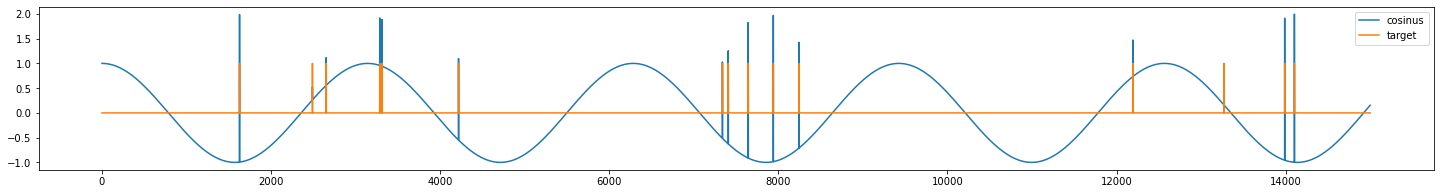

In [175]:
def generate_data(length, test_size=0.2, target_noise_fac=0, usecase='regression'):
        cat_vars = []
        cont_vars = ['noise', 'linear', 'sinus', 'sinus_freq_double', 'cosinus', 'sinus_double']
        dep_vars = ['target']
        info_vars = []
        
        df = pd.DataFrame([],columns=cont_vars+cat_vars+info_vars+dep_vars)
        df['noise'] = np.random.randn(length)
        df['linear'] = np.arange(length)*5/length  # +np.sin(np.linspace(0,3*length,length))
        df['sinus'] = np.sin(np.linspace(0, 3 * length, length))
        df['sinus_freq_double'] = np.cos(np.linspace(0, 3 * length, length))
        df['cosinus'] = np.cos(np.linspace(0, 30, length))
        df['sinus_double'] = 2 * np.sin(np.linspace(0, 10, length))
        
        if usecase == 'regression':
            df['target'] = 50 * np.sin(np.linspace(0, 3 * length, length)) * np.cos(np.linspace(0, 3 * length, length)) + np.arange(length)
        elif usecase == 'classification':
            #df['target'] = (0.5<df['cosinus']).astype(int)
            df['target'] = np.zeros(length)
            idx = np.random.choice(np.arange(0,length),np.random.randint(1,150),replace=False)
            df.loc[idx,'cosinus'] = abs(df.loc[idx,'cosinus'])*2
            df.loc[idx,'target'] = 1
        else:
            assert 0
        if target_noise_fac: 
            df['target'] += np.random.randn(len(df)) * target_noise_fac


        val_start_idx = int((1 - test_size) * len(df))
        train = df.iloc[:val_start_idx]
        val = df.iloc[val_start_idx:]
        return df, train, val, cont_vars, dep_vars
df_raw, train, val, cont_vars, dep_vars = generate_data(15000,usecase='classification',test_size=0.5,)
df_raw[['cosinus','target']].plot(figsize=(25,3))

//miniconda3/envs/fastbook/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:>

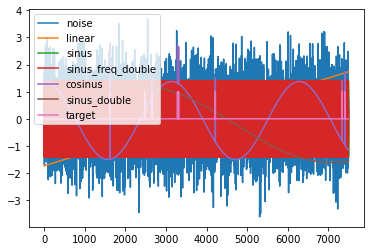

In [176]:
mean = train[cont_vars].mean()
std = train[cont_vars].std()
train[cont_vars] = (train[cont_vars]-mean)/std
val[cont_vars] = (val[cont_vars]-mean)/std
train.plot()

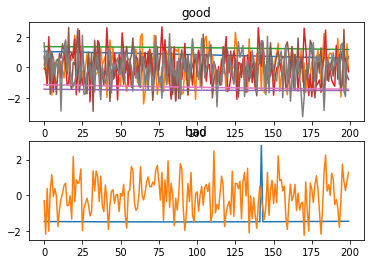

In [182]:
class ClassificationTestdataset(torch.utils.data.Dataset):
    def __init__(self, input_data, input_labels, seq_length):
        self.input_data = torch.from_numpy(input_data).type(torch.FloatTensor)
        self.input_labels = torch.from_numpy(input_labels).type(torch.LongTensor).flatten() #convert to float for regression
        self.seq_length = seq_length
        
    def __getitem__(self, i):
        if i>=len(self): # to stop iterator because sliceing doesn't yield index error
            raise(IndexError)
        return self.input_data[i:i+self.seq_length].T.unsqueeze(0), self.input_labels[i:i+self.seq_length].max()
    
    def __len__(self): return len(self.input_data)-self.seq_length
    
    def show_batch(self,nr_samples=9):
        fig, ax = plt.subplots(2)
        for i in range(nr_samples):
            idx = np.random.randint(len(self))
            label = self[idx][1].numpy()
            data = self[idx][0][0].T.numpy()
            ax[label].plot(data)
        ax[0].set_title('good')
        ax[1].set_title('bad')
        plt.show()

seq_length=200
cont_vars = ['cosinus','noise']
train_ds = ClassificationTestdataset(train[cont_vars].values,train[dep_vars].values, seq_length)
valid_ds = ClassificationTestdataset(val[cont_vars].values,val[dep_vars].values, seq_length)
train_ds.show_batch(5)

In [ ]:
# let's unfreeze the fc2 layer this time for extra tuning
net.fc2.weight.requires_grad = True
net.fc2.bias.requires_grad = True

# add the unfrozen fc2 weight to the current optimizer
optimizer.add_param_group({'params': net.fc2.parameters()})

In [183]:
class TSResnet(nn.Module):
    def __init__(self, keep_layers = ['layer1', 'avgpool']):
        super(TSResnet, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 64, kernel_size=(len(cont_vars),9), stride=(1), bias=False),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU())
        resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
        resnet_layers = [module for name, module in resnet._modules.items() if name in keep_layers]
        self.resnet = nn.Sequential(*resnet_layers)

        self.head = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(64,10),
                        nn.ReLU(),
                        nn.Linear(10,2)
                        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.resnet(x)
        return self.head(x)
model = TSResnet(keep_layers = ['layer1', 'avgpool'])
model(train_ds[0][0].unsqueeze(0))

Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0


tensor([[-0.0433, -0.0886]], grad_fn=<AddmmBackward>)

In [157]:
model.resnet[0]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [76]:
model.encoder[0].weight.shape

torch.Size([64, 1, 2, 9])

In [336]:
model.encoder._modules['0'].weight.requires_grad =False

In [337]:
model.encoder._modules['0'].weight[0].requires_grad 

False

In [338]:
with torch.no_grad():
    for i in range(len(cont_vars)):
        model.encoder._modules['0'].weight[i][:,:,:] = 0
        model.encoder._modules['0'].weight[i][:,i,4] = 1
        print(model.encoder._modules['0'].weight[i][:,:,:])

tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.]]])


In [184]:
dls = DataLoaders.from_dsets(train_ds, valid_ds,bs=64)
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss())
learn.fit_one_cycle(5, 0.01,wd=0.01) 

epoch,train_loss,valid_loss,time
0,0.323028,0.831795,00:18
1,0.091259,0.667494,00:18
2,0.033294,0.540587,00:18
3,0.014487,0.743193,00:17
4,0.009769,0.571270,00:18


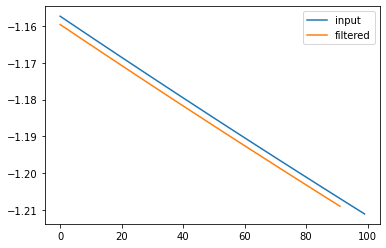

In [344]:
fig, ax = plt.subplots()
ax.plot(x[0].T[:,0],label='input')
ax.plot(model.encoder._modules['0'](x.unsqueeze(0))[0][0].detach().T, label='filtered')
plt.legend()
plt.show()

In [185]:
y_pred = model(torch.stack([entry[0] for entry in valid_ds])).argmax(axis=1)
y = torch.stack([entry[1] for entry in valid_ds])
(y-y_pred).abs().float().mean()

tensor(0.0947)

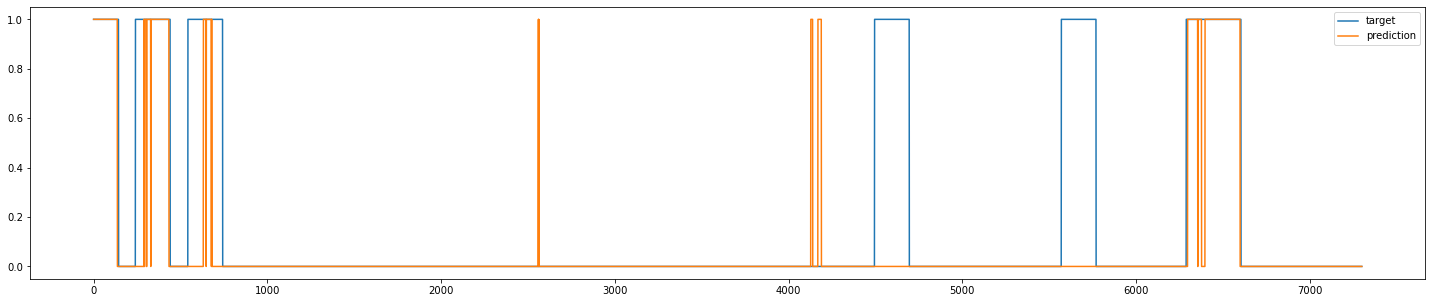

In [186]:
plt.figure(figsize=(25,5))
plt.plot(y,label='target')
plt.plot(y_pred,label='prediction')
plt.legend()
plt.show()

<AxesSubplot:>

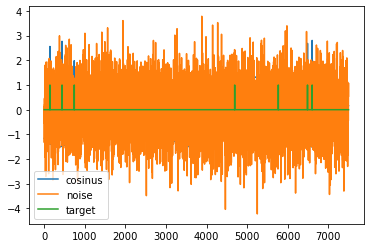

In [187]:
val.reset_index()[cont_vars+dep_vars].plot()

In [36]:
val.target.argmax()

230

In [194]:
ggc = GuidedGradCam(model,use_cuda,target_type='classification', layer_ids=['resnet.0'])#'resnet.1', 'encoder.0'
x,y = valid_ds[400]
input = x.unsqueeze(0)
print(model(input).detach().numpy(),y.numpy())
heatmap, gb, cam_gb = ggc(input.requires_grad_(True))     

register hooks for:
resnet.0
[[-0.7159408  1.2443675]] 1


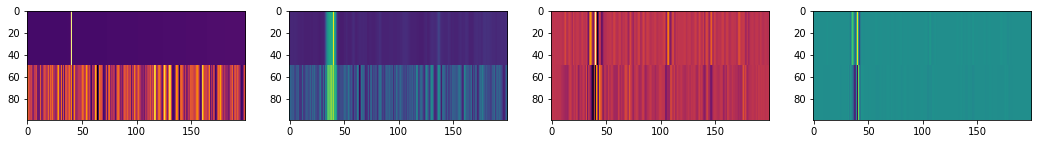

In [199]:
img = transforms.ToPILImage()(min_max_scaler(input[0]))
#img = arr_to_img(input[0].detach().numpy()[0])

fig, ax = plt.subplots(1,4,figsize=(18,6))
ax[0].imshow(img.reshape(100,seq_length),cmap='inferno')
cam = np.float32(img)+np.float32(heatmap)[:,:,0]
ax[1].imshow(arr_to_img(cam).reshape(100,seq_length))
ax[2].imshow(arr_to_img(gb[:,:,0],cmap='inferno').reshape(100,seq_length))
ax[3].imshow(arr_to_img(cam_gb[:,:,0]).reshape(100,seq_length))
plt.show()

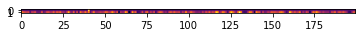

In [200]:
plt.imshow(input[0].detach().cpu().permute(1,2,0).numpy(), 'inferno')

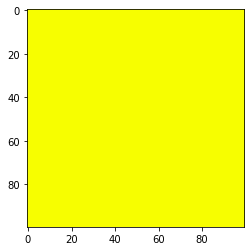

In [43]:
plt.imshow(arr_to_img(input[0].detach().cpu().permute(1,2,0).numpy(), 'inferno').reshape(100,100))

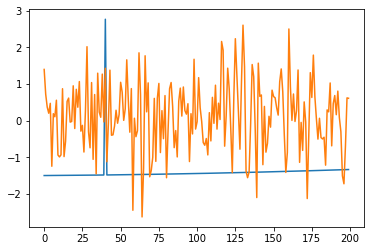

In [196]:
plt.plot(x[0].T)

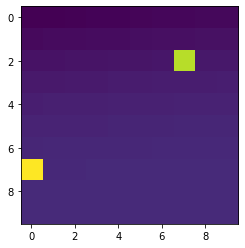

In [45]:
plt.imshow(x[0][0].reshape(10,-1))

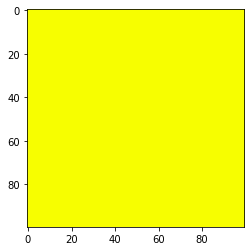

In [46]:
plt.imshow(arr_to_img(input[0].detach().cpu().permute(1,2,0).numpy(), 'inferno').reshape(100,100))

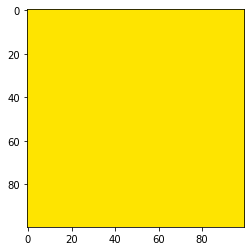

In [47]:
plt.imshow(arr_to_img(input[0].detach().cpu().permute(1,2,0).numpy(), 'viridis').reshape(100,100))

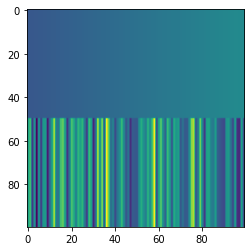

In [400]:
plt.imshow(arr_to_img(x.permute(1,2,0).detach().numpy()).reshape(100,100))

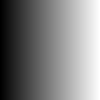

In [48]:
tt = torch.arange(100)/100-0.5
transforms.ToPILImage()(min_max_scaler(tt.unsqueeze(0))).reshape(100,100)

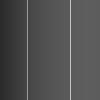

In [49]:
transforms.ToPILImage()(x[:,:1,:]).reshape(100,100)

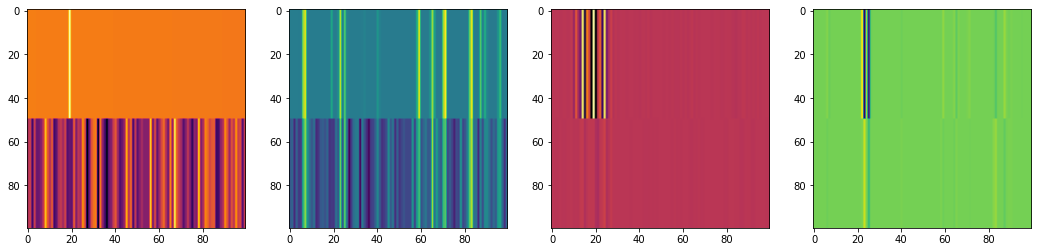

## AugmentationImpactAnalyzer

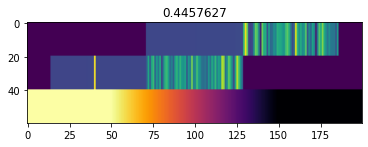

In [327]:
class AugmentationImpactAnalyzer():
    def __init__(self, img, model=None, cuda=False, add_output_act=False, restrict_classes=None, normalize=None,
                 guided_grad_cam=None, resize=None):
        self.img_orig = img.copy()
        self.img = img.copy()
        self.out_img = img.copy()
        self.x_orig = transforms.ToTensor()(img).unsqueeze(0)
        self.x_orig = self.x_orig.cuda() if cuda else self.x_orig
        self.model = model.cuda() if cuda else model
        self.add_output_act = add_output_act
        self.images = []
        self.activations = []
        self.restrict_classes = restrict_classes
        self.class_idx = [int(i) for i in restrict_classes.keys()] if restrict_classes is not None else None
        self.normalize = normalize if normalize is not None else lambda x: x
        self.cuda = cuda
        self.ggc = guided_grad_cam
        self.show_score = True
        self.out_score = None
        self.resize = resize
        
    def reset(self, new_img=None):
        self.img_orig = new_img if new_img is not None else self.img_orig
        self.img = self.img_orig.copy()
        self.x_orig = transforms.ToTensor()(new_img).unsqueeze(0) if new_img is not None else self.x_orig
        self.x_orig = self.x_orig.cuda() if self.cuda else self.x_orig
        self.images = []
        self.activations = []

    def tfm_brightness(self, brightness):
        x = TF.adjust_brightness(self.x, brightness)
        return x

    def tfm_centercrop(self, crop_size):
        x = transforms.CenterCrop(crop_size)(self.x)
        return x

    def tfm_perspective(self, perspective_w=None, perspective_h=None, perspective_d=0):
        width, height = self.x.shape[2:]
        w = perspective_w if perspective_w is not None else width
        h = perspective_h if perspective_h is not None else height
        d = perspective_d
        if (w == width) and (h == height) and (perspective_d == 0):
            # If no transformation should be made, skip!
            # Otherwise TF.perspective will modify the input slightly (e.g. for binary input)
            return self.x
        else:
            startpoints = [[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]]
            endpoints = [[0, 0], [w, d], [w, h], [0, h]]
            return TF.perspective(self.x, startpoints, endpoints, pilImage.BILINEAR)

    def tfm_erase(self, erase_i=0, erase_j=0, erase_h=0, erase_w=0):
        return TF.erase(self.x, erase_i, erase_j, erase_h, erase_w, 0)

    def tfm_rotate(self, angle):
        return TF.rotate(self.x, angle=angle)

    def tfms(self, activation_localization=None, show=True, brightness=None, crop_size=None, rotate_ang=None, **args):
        '''Run function to perform several transformations.
           Args:
               activation_localization (str): {'none','cam','gradient','gradcam'}, default None
                                              Mode for visualizing the parts of the image that affected the model output most
           todo: add more docu
        '''
        self.x = self.x_orig
        # first run all augmentation methods
        # adjust brightness
        if brightness is not None:
            self.x = self.tfm_brightness(brightness)
        # center crop the image
        if crop_size is not None:
            self.x = self.tfm_centercrop(crop_size)
        # rotate the image
        if rotate_ang is not None:
            self.x = self.tfm_rotate(rotate_ang)
        # perspective distorition
        perspective_args = {k: v for k, v in args.items() if 'perspective' in k}
        if len(perspective_args):
            self.x = self.tfm_perspective(**perspective_args)
        # erase part of the image
        erase_args = {k: v for k, v in args.items() if 'erase' in k}
        if len(erase_args):
            self.x = self.tfm_erase(**erase_args)

        # then run activation localization
        if (activation_localization is not None) & (activation_localization != 'none'):
            if self.ggc is None:
                assert 0, "Please provide a guided_grad_cam model first"
            x_input = self.normalize(self.x).requires_grad_(True)
            if activation_localization == 'gradcam':
                heatmap = self.ggc.grad_cam.get_heatmap(x_input)
                # need to renormalize the image before adding it to another image
                act_loc = tensor_to_np_img(min_max_scaler(self.x[0].detach())) + np.float32(heatmap)
            elif activation_localization == 'guided-gradient':
                act_loc = self.ggc.gb_model.get_gradient_act(x_input)
            elif activation_localization == 'guided-gradcam':
                _, _, act_loc = self.ggc(x_input)
            else:
                assert 0, f'activation_localization "{activation_localization}" not known'

            out_img = act_loc
        else:
            out_img = self.x[0].detach().cpu().permute(1,2,0).numpy()



        if ((len(out_img.shape) == 3) and (out_img.shape[2] == 1)):
            self.out_img = arr_to_img(out_img,'viridis')
        else:
            self.out_img = arr_to_img(out_img)
        
        if self.resize is not None:
            self.out_img = self.out_img.reshape(*self.resize)
            
        # then add model activation
        # Note: Here we use a different model as in the activation localization.
        # We coul use the same model and use reuse model output from forward pass above but it might add unnecessary complexity
        if self.add_output_act:
            out = self.model(self.normalize(self.x)).cpu().detach().numpy()
            if self.restrict_classes is not None:
                out = out[:, self.class_idx]
            self.activations.append(out)
            self.out_score = out.max()
            self.out_img = self.combine_activation_with_img(self.out_img, out)
        elif self.show_score:
            out = self.model(self.normalize(self.x)).cpu().detach().numpy()
            self.out_score = out.max()
        else:
            pass

        self.out_img = arr_to_img(self.out_img)
        self.images.append(self.out_img)

        if show:
            fig, ax = plt.subplots()
            if self.restrict_classes is not None:
                my_xticks = self.restrict_classes.values()
                nr_classes = len(self.restrict_classes)
                h, w = self.out_img.shape
                step_size = w / nr_classes
                ax.set_xticks(np.arange(nr_classes) * step_size + (step_size // 2))
                ax.set_xticklabels(my_xticks, rotation=90)
            if self.show_score:
                plt.title(self.out_score)
            ax.imshow(self.out_img)

    def combine_activation_with_img(self, img, act):
        # to make flatten activation better visible, the images will be streched by a factor of 20
        # and the width is adapted to the original image width
        shape = (20, img.shape[1])
        # combine transformed images and their layer activations
        act = arr_to_img(imresize(act, shape),'inferno')
        # to work also with 2D images (e.g. timeseries)
        img_comb = np.vstack([img, act])
        return img_comb

    def create_gif(self, path):

        #if self.add_output_act:
        #    # to make flatten activation better visible, the images will be streched by a factor of 20 and the width is adapted to the original image width
        #    w, h = self.images[0].shape
        #    transform_act = lambda x: arr_to_img(imresize(x, (20, w)), 'inferno')
        #    # combine sequence of transformed images and their layer activations
        #    imgs_combs = [np.vstack([arr_to_img(img).resize((w, h)), transform_act(act)]) for img, act in
        #                  zip(self.images, self.activations)]
        #    images = [pilImage.fromarray(img) for img in imgs_combs]
        #else:
        #    images = self.images

        # transform to images, add backward loop and store as gif
        first_img, *imgs = self.images
        imgs += [img for img in imgs[::-1]]
        first_img.save(fp=path, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)

input = valid_ds[400][0].unsqueeze(0)
img = transforms.ToPILImage()(min_max_scaler(input[0]))

aia = AugmentationImpactAnalyzer(img, model, guided_grad_cam=ggc, add_output_act=True, resize=(20*img.shape[0],img.shape[1]))
aia.tfms(erase_w=10,erase_h=10,rotate_ang=1,activation_localization=None)

In [330]:
width, height = aia.img.shape

import ipywidgets as widgets
def create_gif_on_click(change):
    os.makedirs('../imgs/',exist_ok=True)
    aia.create_gif(IMGS_PATH/'results.gif')

btn_create_gif = widgets.Button(description='Create gif')
btn_create_gif.on_click(create_gif_on_click)

btn_act_loc = widgets.RadioButtons(
    options=['none','gradcam','guided-gradient','guided-gradcam',],
    description='Activation Localization:',
    disabled=False)

sl_brightness = widgets.FloatSlider(value=1,min=0.1,max=4,step=0.2)
box_brightness = widgets.VBox([widgets.HTML('<em>Brightness</em>'),sl_brightness])

sl_crop_size = widgets.IntSlider(value=max(width,height),min=min(width,height,32),max=max(width,height),step=5)
box_crop = widgets.VBox([widgets.HTML('<em>Center Crop</em>'),sl_crop_size])

sl_rotate = widgets.IntSlider(value=0,min=0,max=360,step=5)
box_rotate = widgets.VBox([widgets.HTML('<em>Rotation Angle</em>'),sl_rotate])
sl_perspective_w = widgets.IntSlider(value=width,min=0,max=width,step=5)
sl_perspective_h = widgets.IntSlider(value=height,min=0,max=height,step=5)
sl_perspective_d = widgets.IntSlider(value=0,min=0,max=height,step=5)
box_perspective = widgets.VBox([widgets.HTML('<em>Perspective Distortion</em>'),sl_perspective_w,sl_perspective_h,sl_perspective_d])

sl_erase_i = widgets.IntSlider(value=0,min=0,max=width,step=1)
sl_erase_j = widgets.IntSlider(value=0,min=0,max=height,step=1)
sl_erase_w = widgets.IntSlider(value=0,min=0,max=height,step=1)
sl_erase_h = widgets.IntSlider(value=0,min=0,max=height,step=1)
box_erase = widgets.VBox([widgets.HTML('<em>Erase Box</em>'),sl_erase_i,sl_erase_j,sl_erase_w, sl_erase_h])

btn_upload = widgets.FileUpload(description='Your Image')

tfm_args_sl = { "brightness":sl_brightness,
                "crop_size":sl_crop_size,
                "activation_localization":btn_act_loc, 
                "rotate_ang":sl_rotate,
                "perspective_w":sl_perspective_w,
                "perspective_h":sl_perspective_h,
                "perspective_d":sl_perspective_d,
                "erase_i":sl_erase_i,
                "erase_j":sl_erase_j,
                "erase_w":sl_erase_w,
                "erase_h":sl_erase_h}
#tfm_args = {k:v.value for k,v in tfm_args_sl.items()}

In [331]:
#aia.reset(PILImage.create((path/"train/n02102040").ls()[32]).resize((size,size)))  
aia.reset(img)
out_tfms = widgets.interactive_output(aia.tfms, tfm_args_sl)
gui = widgets.HBox([widgets.VBox([btn_upload, box_brightness, box_crop, box_rotate, box_perspective, box_erase,
                            btn_act_loc, btn_create_gif]), out_tfms])

def on_upload_change(change):
    aia.reset(PILImage.create(btn_upload.data[-1]))
    if btn_act_loc.value != 'none':
        btn_act_loc.value = 'none'
    else:
        # quick (ugly) hack to reload the image for sure
        if sl_crop_size.value != width:
            sl_crop_size.value = width
        else:
            sl_crop_size.value = sl_crop_size.value - sl_crop_size.step 
    #aia.tfms(**tfm_args) #doesn't reset the gui output

btn_upload.observe(on_upload_change, names='_counter')
display(gui)

[Open Gif](../imgs/results.gif "segment")


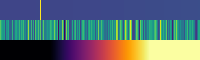

In [320]:
aia.images[0]

### Backlog

In [141]:
input_dim = np.prod(train_ds[0][0].shape)
print(input_dim)
nr_kernels = 30
simple_net = nn.Sequential(
    nn.Conv2d(1, nr_kernels, kernel_size=(2,1), stride=(1), bias=False),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(nr_kernels,10),
    nn.ReLU(),
    nn.Linear(10,2,bias=False),
)
simple_net(train_ds[0][0].unsqueeze(0))
model = simple_net

200


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
training_generator = torch.utils.data.DataLoader(train_ds, **params)

In [21]:
loss_list = []
for i in range(10):
    for x, y in training_generator:
        x, y = x.to(device), y.to(device)
       #compute loss
        y_pred = model(x)
        loss = criterion(y_pred, y)

        # compute gradients and update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_list.append(loss.item())
plt.plot(loss_list)


KeyboardInterrupt: 

In [194]:
validation_generator = torch.utils.data.DataLoader(valid_ds, batch_size=256)

with torch.set_grad_enabled(False):
    for x, y in validation_generator:
        x, y = x.to(device), y.to(device)
        #compute loss
        y_pred = model(x)
        print((y_pred.argmax(axis=1)-y).abs().numpy().mean())
        #loss = criterion(y_pred, y)
        #print(loss.item())


0.0
0.0
0.1796875
0.0
0.0
0.0
0.0
0.0
